In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [2]:
df = pd.read_csv(r'D:\projects\XGboost regression\archive\PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

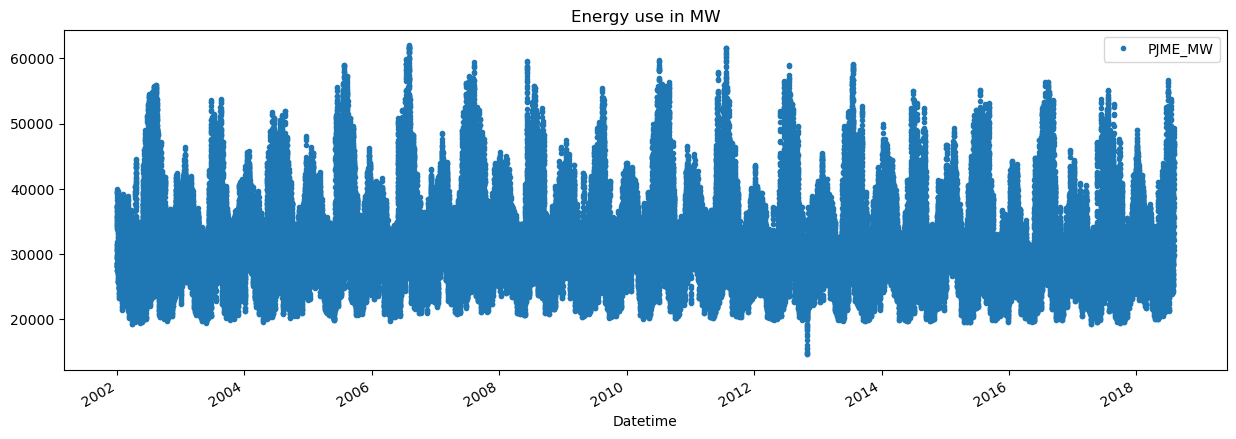

In [3]:
df.plot(style='.',
        figsize=(15,5), 
        title='Energy use in MW')
plt.show()

<Axes: ylabel='Frequency'>

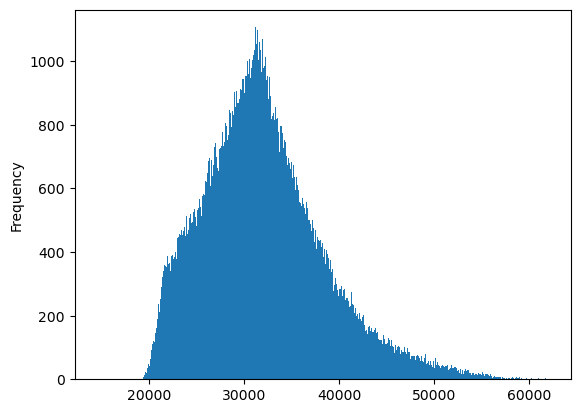

In [4]:
# looking for outlier (notice the dip in above plot near 2013)
df['PJME_MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'outliers'}, xlabel='Datetime'>

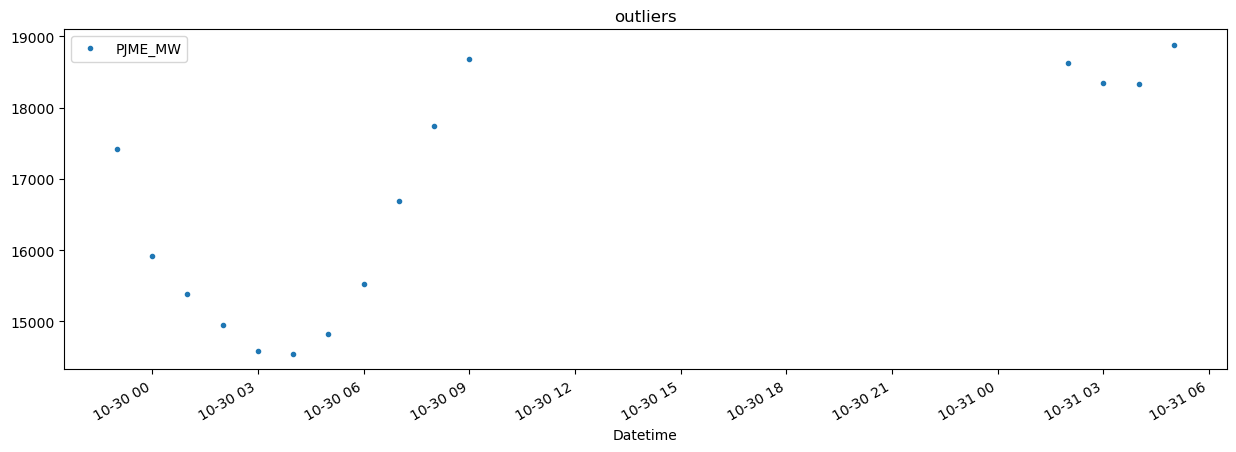

In [5]:

df.query('PJME_MW < 19_000').plot(style='.', figsize=(15,5), title='outliers')

In [6]:
# Remove the outliers
df = df.query('PJME_MW > 19_000').copy()

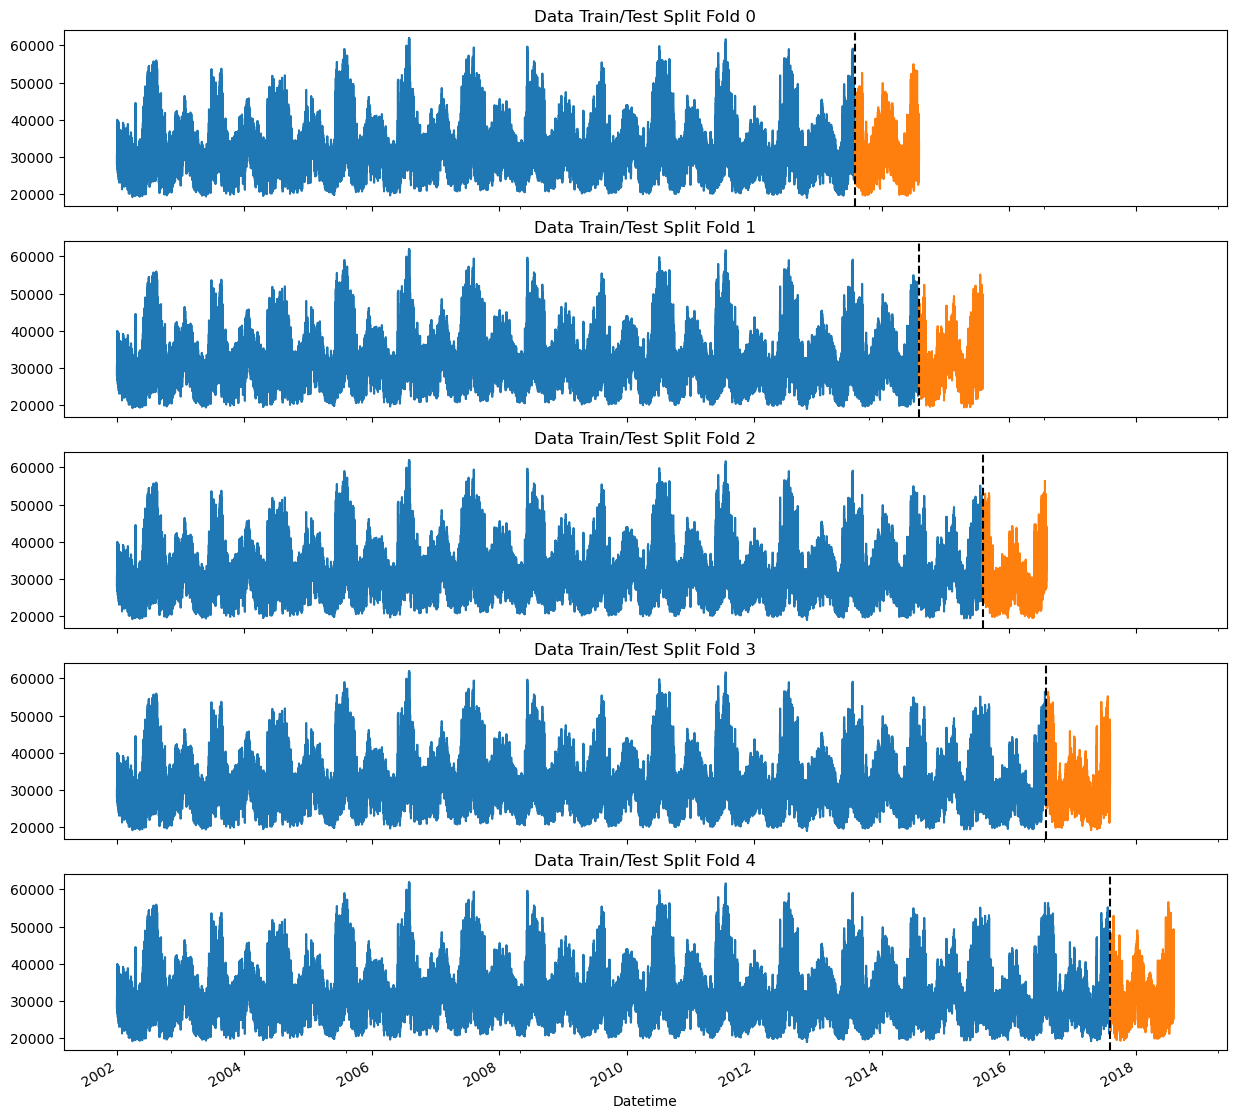

In [7]:
# Time series Train/Test split
from sklearn.model_selection import TimeSeriesSplit

Tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in Tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

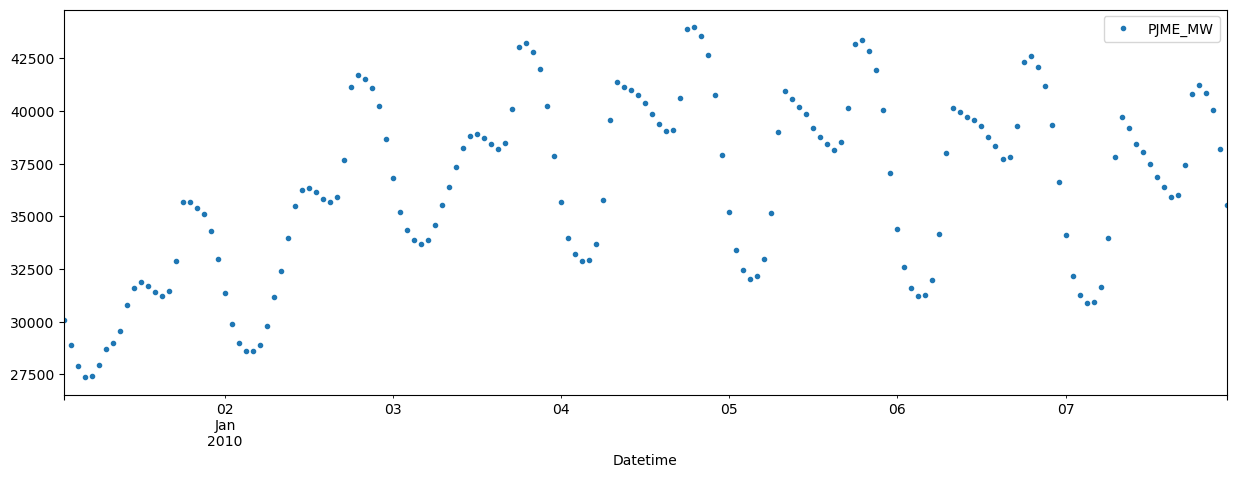

In [8]:
week = df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(style='.',figsize=(15,5)) 
plt.show()

In [9]:
# Feature Creation

def create_features(df):
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    
    return df

df = create_features(df)

In [10]:
# Lag Features

def add_lag(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lag(df)

Text(0.5, 1.0, 'MW by hour')

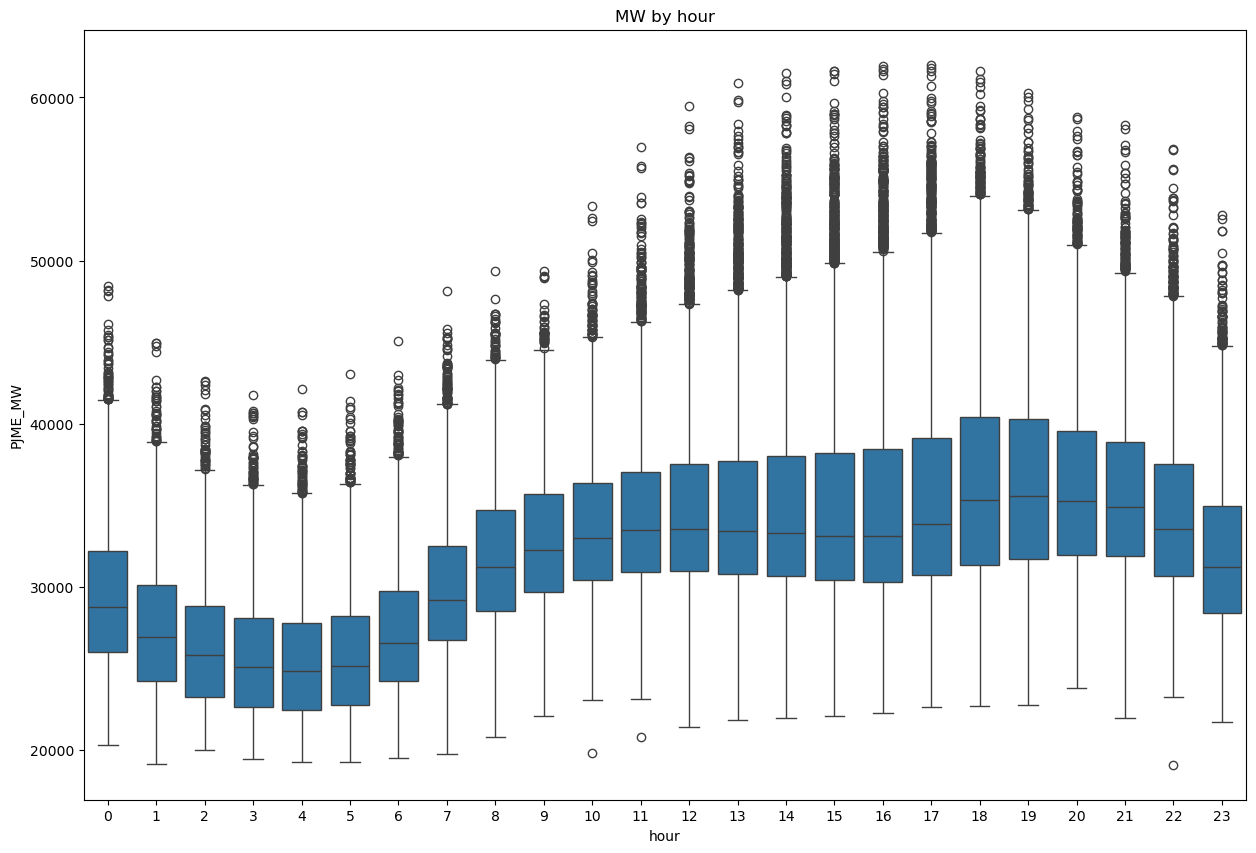

In [11]:
# visualize feature - targert relationship
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by hour')


Text(0.5, 1.0, 'MW by month')

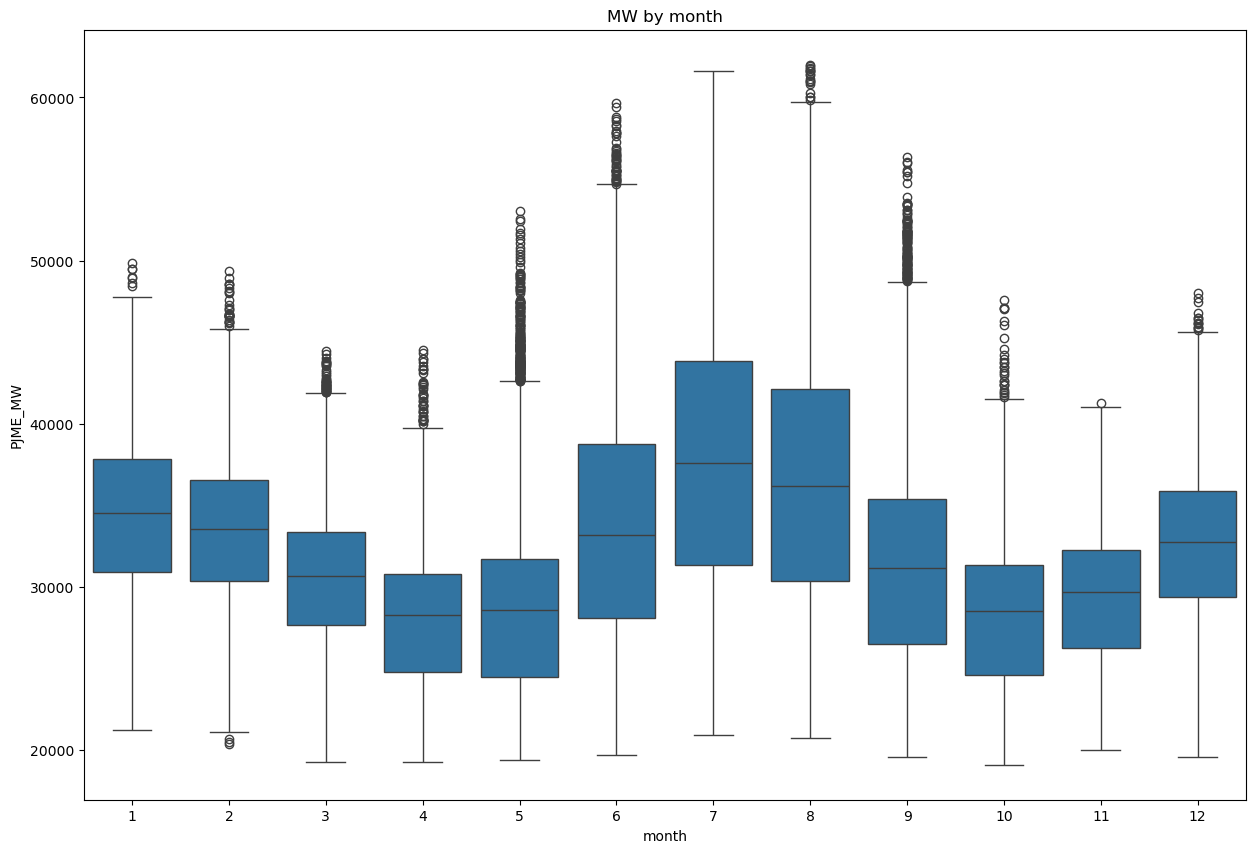

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=df, x='month', y='PJME_MW')
ax.set_title('MW by month')

Text(0.5, 1.0, 'MW by year')

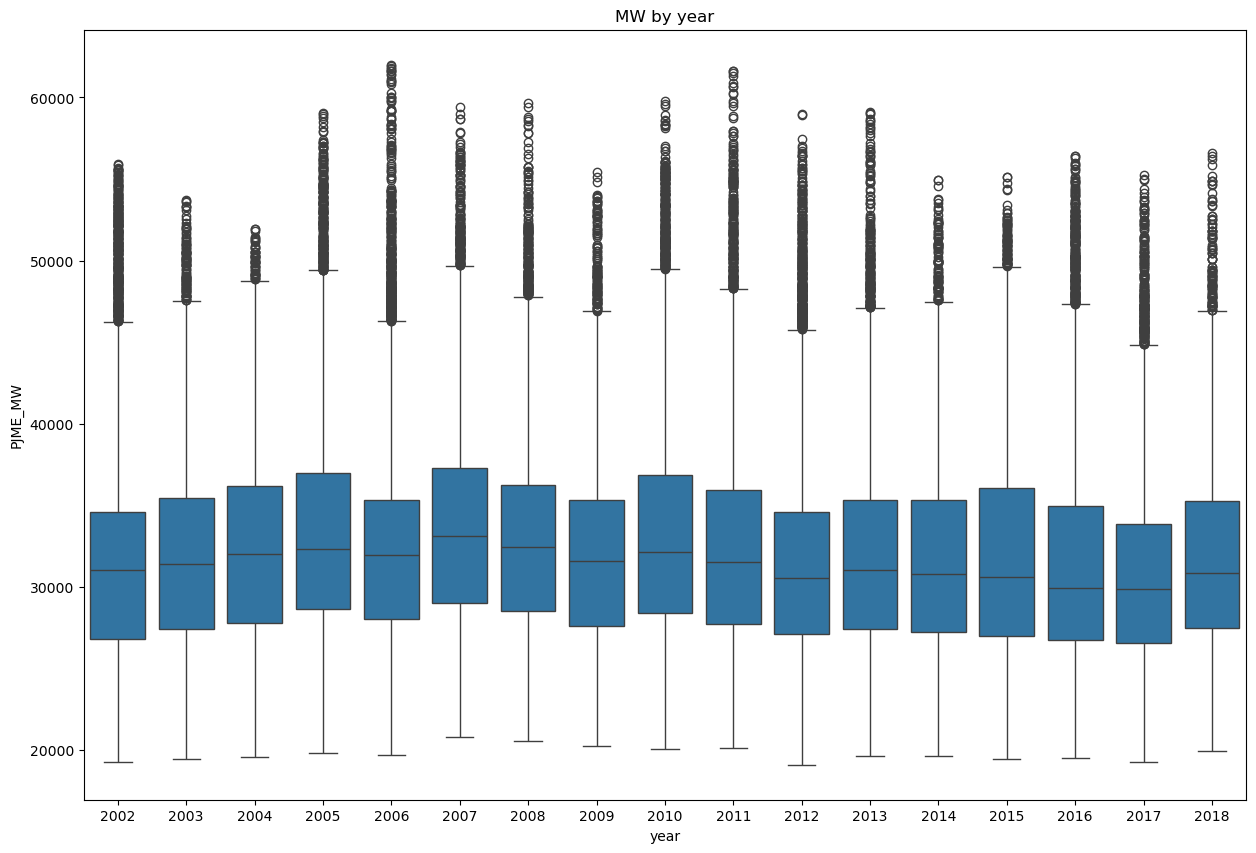

In [13]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=df, x='year', y='PJME_MW')
ax.set_title('MW by year')

In [14]:
# Train using cross validation  

Tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in Tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
                'dayofyear', 'dayofmonth', 'lag1', 'lag2', 'lag3' ]
    targets =  'PJME_MW'  
    
    x_train = train[features]
    y_train = train[targets]
    
    x_test = test[features]
    y_test = test[targets]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(x_train, y_train,
            eval_set= [(x_train, y_train), (x_test, y_test)],
            verbose=100)    
    
    y_pred = reg.predict(x_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
       

[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163
[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.45680	validation_1-rmse:3900.22955
[400]	validation_0-rmse:3434.17801	validation_1-rmse:3760.50563
[449]	validation_0-rmse:3360.62266	validation_1-rmse:3765.82107
[0]	validation_0-rmse:32672.16678	validation_1-rmse:32138.89241
[100]	validation_0-rmse:12513.65574	validation_1-rmse:12224.93373
[200]	validation_0-rmse:5753.34937	validation_1-rmse:5662.07107
[300]	validation_0-rmse:3901.81375	validation_1-rmse:3938.21895
[400]	validation_0-rmse:3476.22836	validation_1-rmse:3593.56886
[500]	validation_0-rmse:3353.06093	validation_1-rmse:3518.24050
[600]	validation_0-rmse:3296.74358	validation_1-rmse:3484.89125
[700]	validation_0-rmse:3256.68865	validation_1-rmse:3460.24678
[800]	validation_0-rmse:3218.54437	validation_1-rmse:3441.66955
[900]	validation_0-rmse:3187.41141	v

<Axes: title={'center': 'Feature Importances'}>

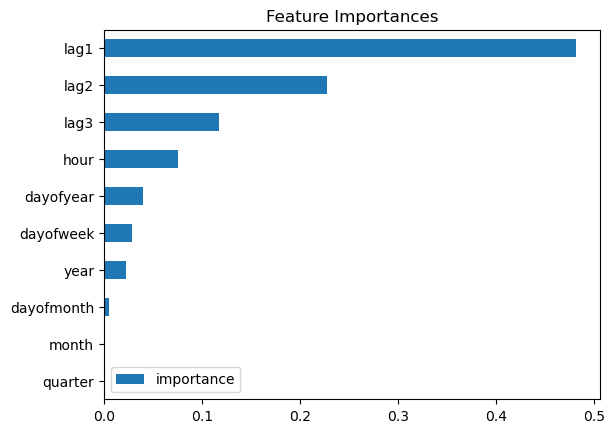

In [15]:
FI = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
FI.sort_values('importance').plot(kind='barh', title='Feature Importances')

In [16]:
#forecast on test

test['predictions'] = reg.predict(x_test)
df = df.merge(test[['predictions']], how='left', left_index=True, right_index=True )


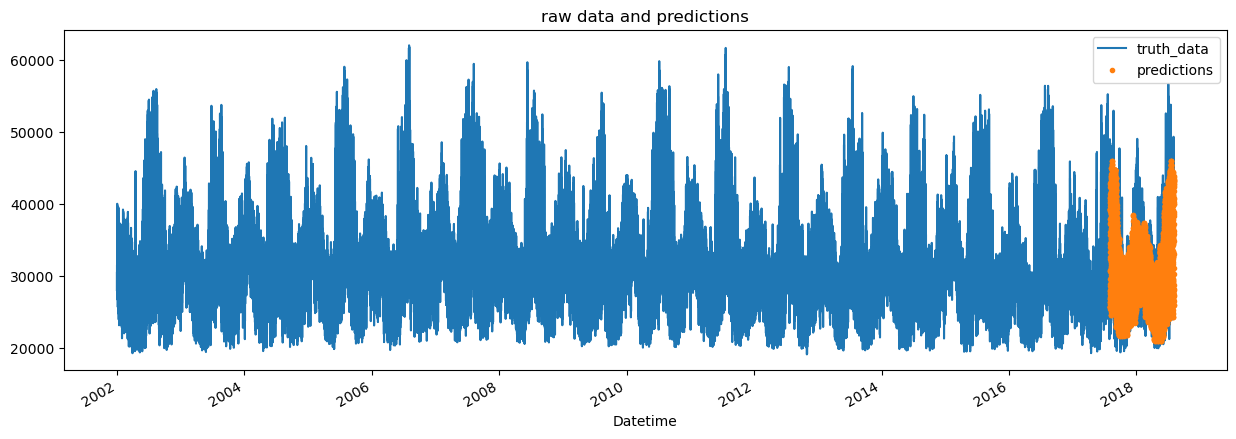

In [17]:

ax = df[['PJME_MW']].plot(figsize=(15,5))
df['predictions'].plot(ax=ax, style='.')
plt.legend(['truth_data', 'predictions'])
ax.set_title('raw data and predictions')
plt.show()

In [18]:
'''
ax = df.loc[(df.index > '01-07-2018') & (df.index < '08-07-2018')]['PJME_MW'] \
    .plot(style='.', figsize=(15,5))
df.loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')]['predictions'] \
    .plot(style='.')
plt.legend(['truth', 'prediction'])
plt.show()
'''

"\nax = df.loc[(df.index > '01-07-2018') & (df.index < '08-07-2018')]['PJME_MW']     .plot(style='.', figsize=(15,5))\ndf.loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')]['predictions']     .plot(style='.')\nplt.legend(['truth', 'prediction'])\nplt.show()\n"

In [20]:
# ReTrain on all data

df = create_features(df)

features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
                'dayofyear', 'dayofmonth', 'lag1', 'lag2', 'lag3' ]
targets =  'PJME_MW' 

x_all = df[features]
y_all = df[targets]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    
reg.fit(x_all, y_all,
        eval_set= [(x_all, y_all)],
        verbose=100)    
 

[0]	validation_0-rmse:32403.75827
[100]	validation_0-rmse:12426.71698
[200]	validation_0-rmse:5752.88242
[300]	validation_0-rmse:3971.39460
[400]	validation_0-rmse:3571.32465
[500]	validation_0-rmse:3455.94973
[600]	validation_0-rmse:3401.50661
[700]	validation_0-rmse:3365.42910
[800]	validation_0-rmse:3332.76221
[900]	validation_0-rmse:3306.03577
[999]	validation_0-rmse:3283.72059


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [22]:
# create a future datafram
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_with_future = pd.concat([df, future_df])
df_with_future = create_features(df_with_future)
df_with_future = add_lag(df_with_future)

In [23]:
future_with_features = df_with_future.query('isFuture').copy()

In [24]:
future_with_features

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,lag1,lag2,lag3,predictions,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,33539.0,32094.0,31695.0,NaN,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,30781.0,29503.0,29128.0,NaN,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,29015.0,27712.0,27373.0,NaN,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,27884.0,26535.0,26233.0,NaN,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,27223.0,25870.0,25643.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,46912.0,39352.0,40243.0,NaN,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,45985.0,38699.0,39183.0,NaN,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,44094.0,37346.0,37759.0,NaN,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,40666.0,34555.0,34641.0,NaN,True


<Axes: title={'center': 'Future prediction'}>

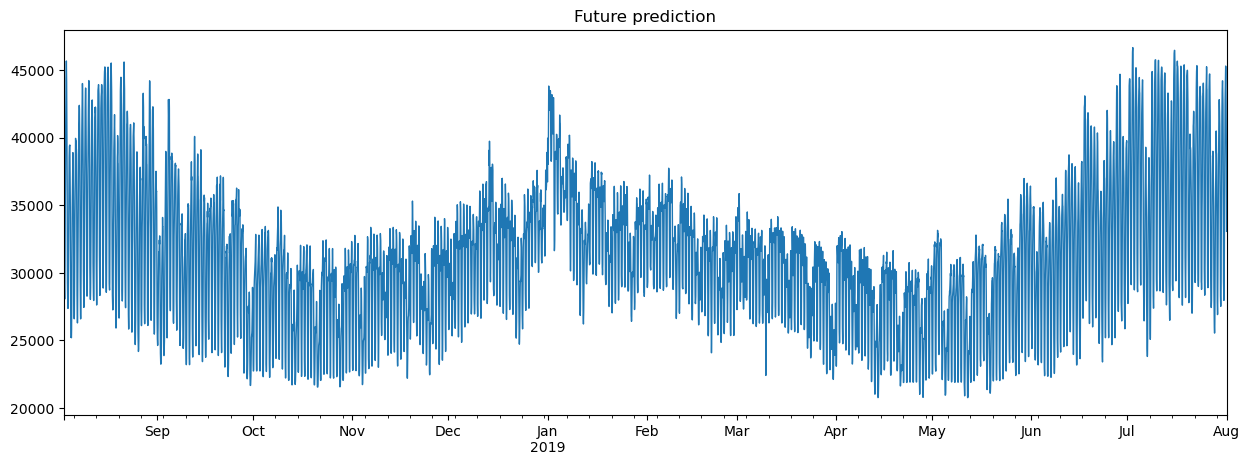

In [31]:
# Predict the Future

future_with_features['pred'] = reg.predict(future_with_features[features])

future_with_features['pred'].plot(figsize=(15,5),
                                  ms=1,
                                  lw=1,
                                  title='Future prediction')

In [27]:
# saving the model

reg.save_model('model.json')

In [30]:
reg_trained = xgb.XGBRFRegressor()
reg_trained.load_model('model.json')

<Axes: title={'center': 'Future prediction'}>

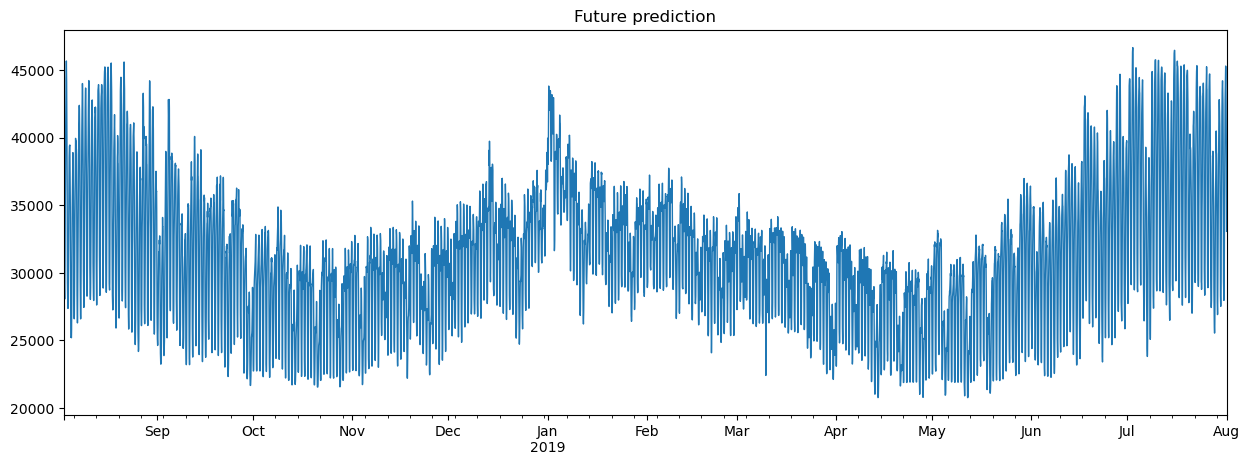

In [36]:
future_with_features['pred'] = reg_trained.predict(future_with_features[features])

future_with_features['pred'].plot(figsize=(15,5),
                                  ms=1,
                                  lw=1,
                                  title='Future prediction')